In [1]:
suppressPackageStartupMessages(library(dplyr)) 
library(ggplot2)
library(pheatmap)
library(RColorBrewer)
suppressPackageStartupMessages(library(Seurat))
suppressPackageStartupMessages(library(EnsDb.Mmusculus.v79))
source("/oasis/tscc/scratch/y2xie/28.FC_16k_Droplet_PT_221210/05.R/DPT_help.R") ### helper code

Warning message:
“package ‘GenomeInfoDb’ was built under R version 4.1.3”


In [2]:
getwd()
subdir <- "."

[1] "/oasis/tscc/scratch/y2xie/28.FC_16k_Droplet_PT_221210/05.R/Preprocess"

# Integration with Paired-Tag & MOp 10XscRNA-seq

In [4]:
path <- "/oasis/tscc/scratch/y2xie/28.FC_16k_Droplet_PT_221210/"
### Droplet Paired-Tag
mmg <- readRDS("FC_RNA_Seurat_merged_rmScrublet.rds")
mmg <- subset(mmg, RNA_keep_cells == "True")
### 10XscRNA-seq
aibs <- readRDS("/home/y2xie/scratch/public_data/NeMO/Analysis_10X_nuclei_v3_AIBS/aibs.rds")
### paired-Tag
ptmmg <- readRDS("/home/y2xie/scratch/public_data/13.Paired-Tag/05.R/seurat_object/FC_Paired-Tag_RNA.seurat.rds")

### 3-ways integration

Scaling features for provided objects

Finding all pairwise anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 38098 anchors

Filtering anchors

	Retained 18885 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 24407 anchors

Filtering anchors

	Retained 10789 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 20681 anchors

Filtering anchors

	Retained 12211 anchors

Merging dataset 3 into 2

Extracting anchors for merged samples

Finding integration vectors

Finding integration vector weights

Integrating data

Merging dataset 2 3 into 1

Extracting anchors for merged samples

Finding integration vectors

Finding integration vector weights

Integrating data



,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,10029465,535.7,14776015,789.2,14776015,789.2
Vcells,1954064292,14908.4,4386093365,33463.3,4386085282,33463.2


Warning message:
"The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session"
23:35:17 UMAP embedding parameters a = 0.9922 b = 1.112

23:35:18 Read 73635 rows and found 30 numeric columns

23:35:18 Using Annoy for neighbor search, n_neighbors = 30

23:35:18 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

23:35:27 Writing NN index file to temp file /scratch/y2xie/30878819.tscc-mgr7.local/RtmpHnQ7nk/file21ca5355a9ac

23:35:27 Searching Annoy index using 1 thread, search_k = 3000

23:35:53 Annoy recall = 100%

23:35:54 Commencing smooth kNN distance calibration using

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 73635
Number of edges: 2928545

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9506
Number of communities: 26
Elapsed time: 26 seconds


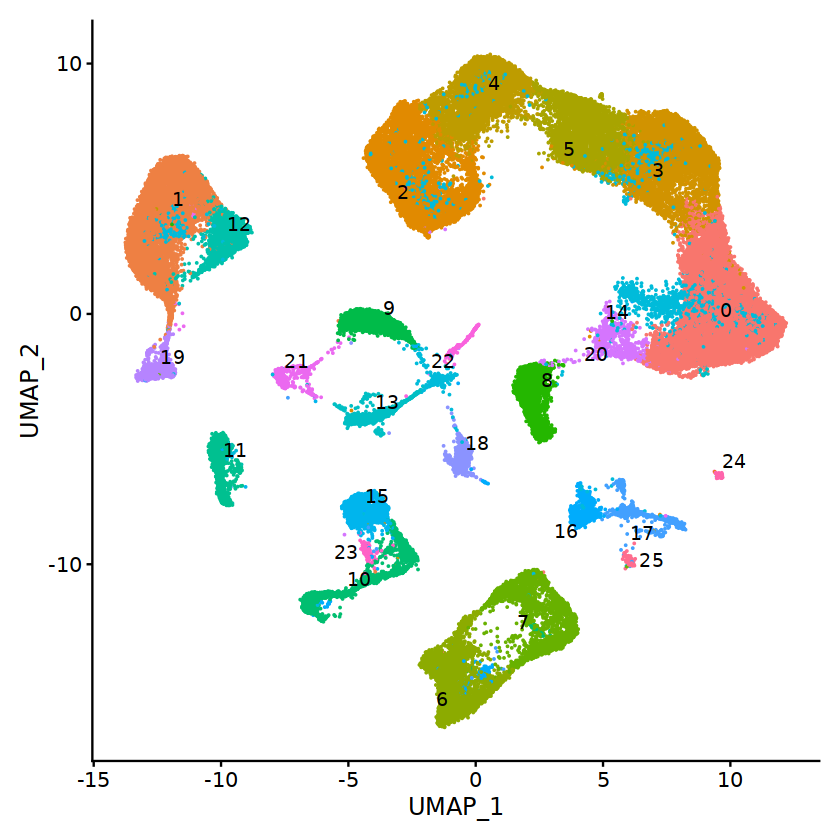

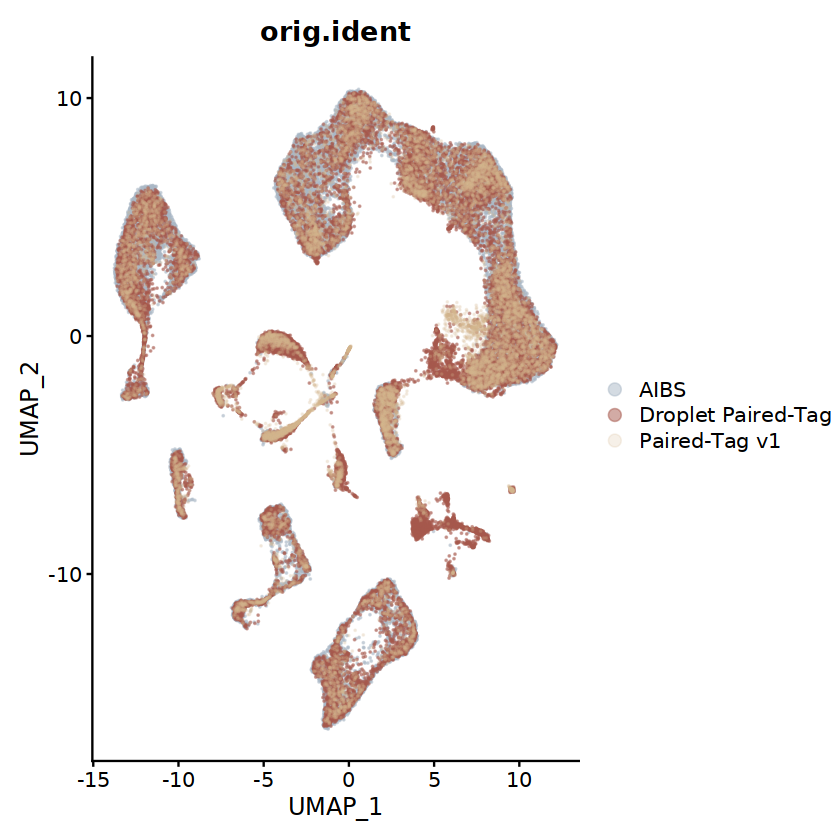

In [5]:
obj.list <- list(aibs, mmg, ptmmg)
obj.list <- lapply(X = obj.list, FUN = function(x) {
    x <- NormalizeData(x)
    x <- FindVariableFeatures(x, selection.method = "vst", nfeatures = 2000)
})
int.features <- SelectIntegrationFeatures(object.list = obj.list)
obj.anchors <- FindIntegrationAnchors(object.list = obj.list, anchor.features = int.features)
obj <- IntegrateData(anchorset = obj.anchors)
gc()

DefaultAssay(obj) <- "integrated"
obj <- ScaleData(obj, verbose = FALSE)
obj <- RunPCA(obj, npcs = 30, verbose = FALSE)
obj <- RunUMAP(obj, reduction = "pca", dims = 1:30)
obj <- FindNeighbors(obj, reduction = "pca", dims = 1:30)
obj <- FindClusters(obj, resolution = 0.5)

DimPlot(obj, label = T, repel = T) + NoLegend()

obj@meta.data[!is.na(obj$Annotation), ]$orig.ident <- "Paired-Tag v1"
obj@meta.data[!is.na(obj$subclass_label), ]$orig.ident <- "AIBS"
obj@meta.data[!is.na(obj$Anno0.8_yel), ]$orig.ident <- "Droplet Paired-Tag"

t1 <- DimPlot(obj, group.by = "orig.ident", size = 0.1, 
        cols = c(alpha("#A9B8C6",0.5), alpha("#A5594D",0.5), alpha("#D2B48C",0.2)))
t1

### Check distribution of all datasets


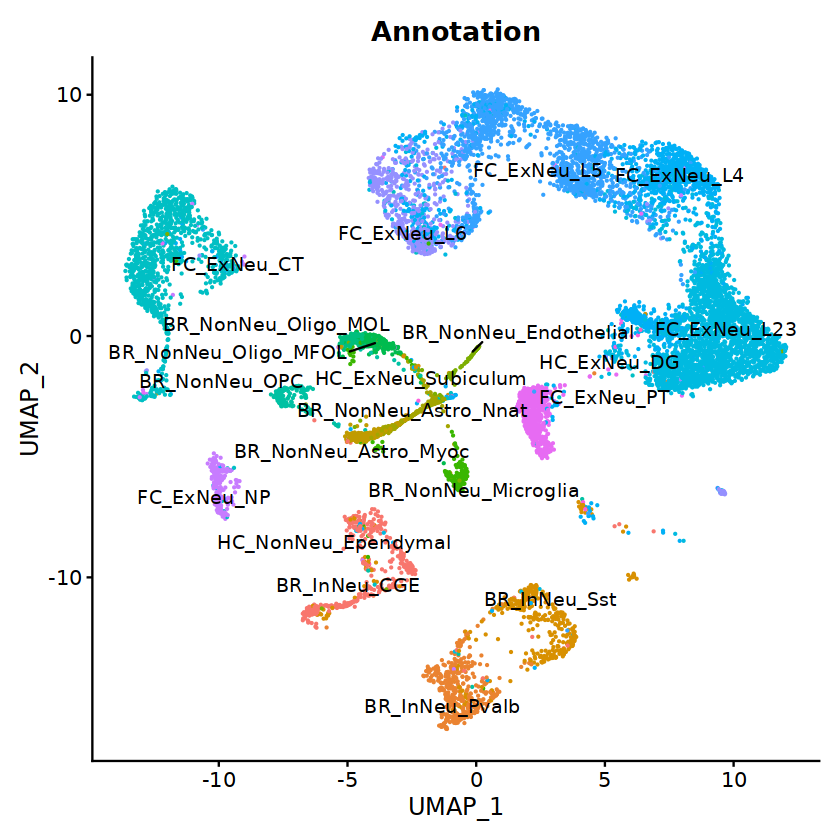

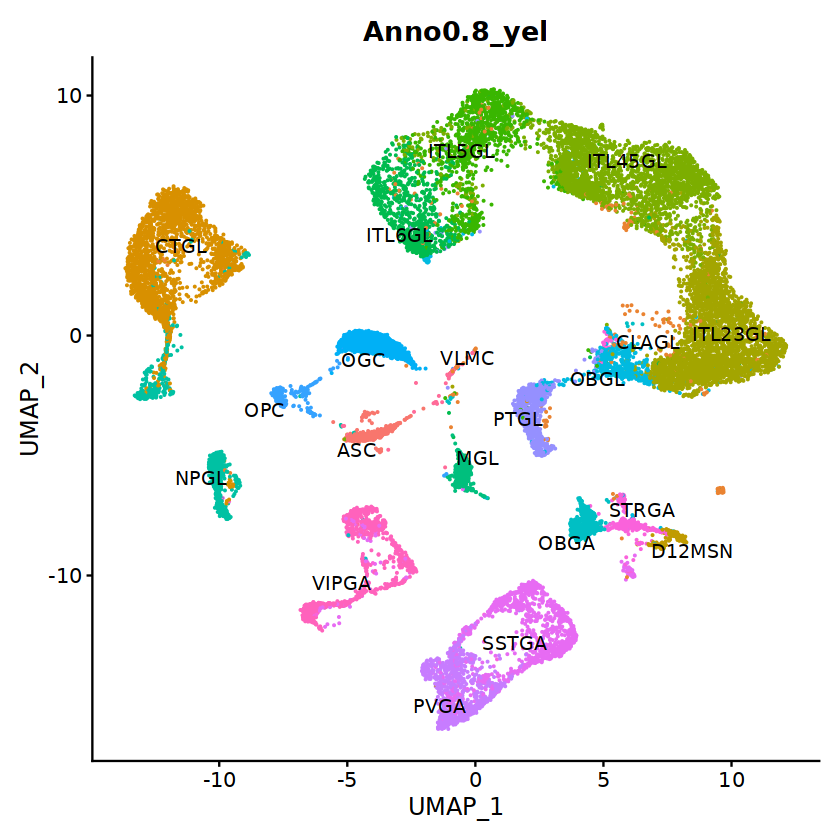

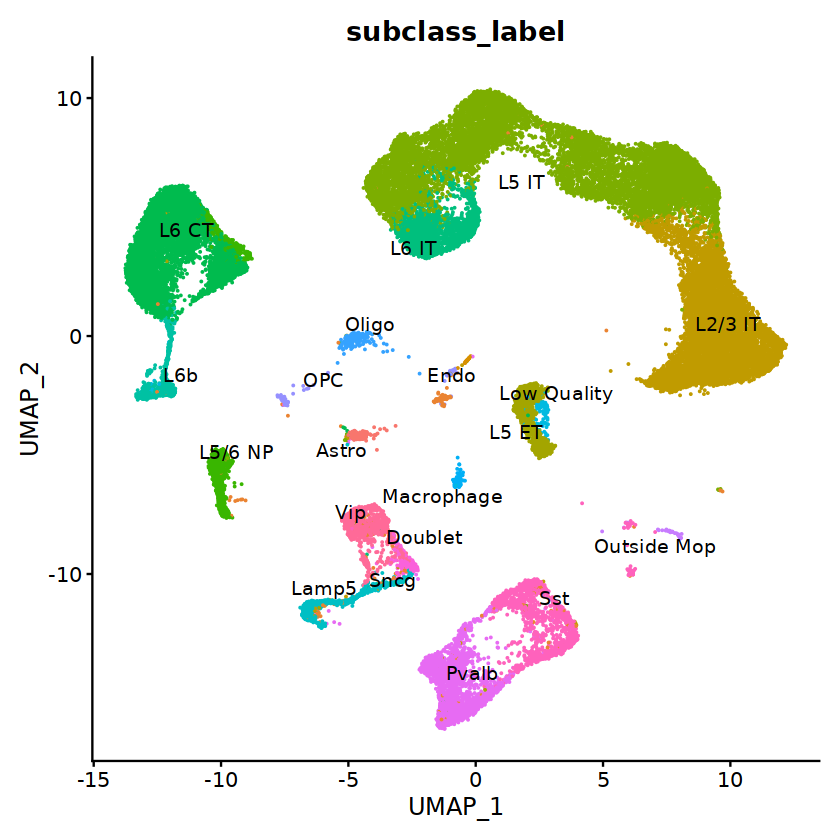

In [6]:
DimPlot(obj, label = T, repel = T, group.by = "Annotation", 
        cells = rownames(obj@meta.data[!is.na(obj$Annotation),])) + NoLegend()
DimPlot(obj, label = T, repel = T, group.by = "Anno0.8_yel", 
        cells = rownames(obj@meta.data[!is.na(obj$Anno0.8_yel),])) + NoLegend()
DimPlot(obj, label = T, repel = T, group.by = "subclass_label", 
        cells = rownames(obj@meta.data[!is.na(obj$subclass_label),])) + NoLegend()

### Match between Droplet Paired-Tag and Paired-Tag


Using ovlpScore as value column: use value.var to override.

Using qry as id variables



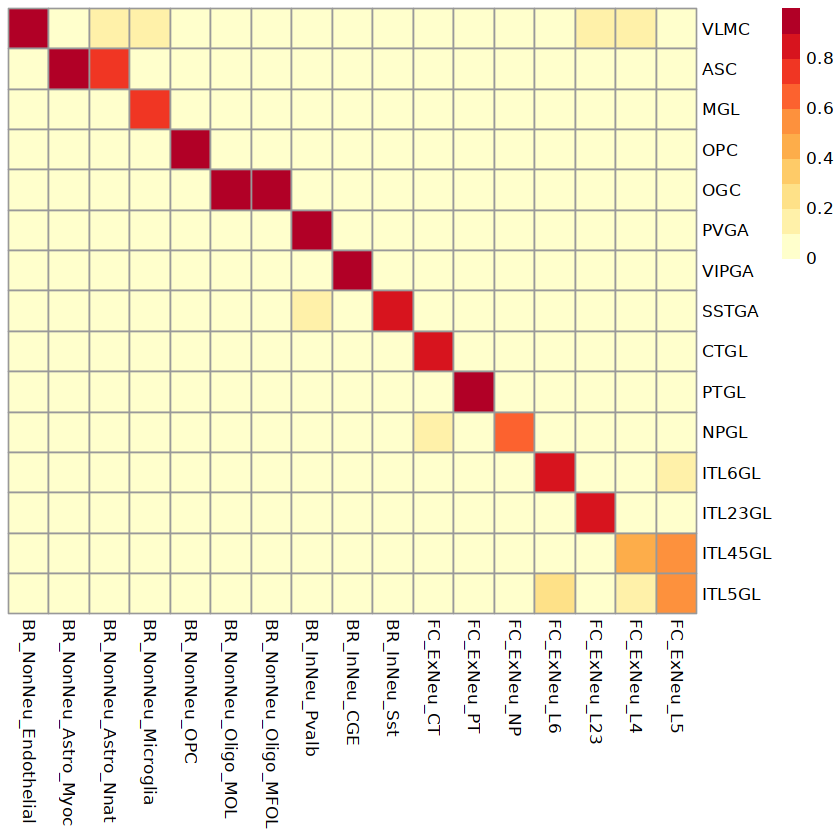

In [7]:
rorder <- c("BR_NonNeu_Endothelial", "BR_NonNeu_Astro_Myoc", "BR_NonNeu_Astro_Nnat", "BR_NonNeu_Microglia",
            "BR_NonNeu_OPC", "BR_NonNeu_Oligo_MOL", "BR_NonNeu_Oligo_MFOL", "BR_InNeu_Pvalb", "BR_InNeu_CGE",
            "BR_InNeu_Sst", "FC_ExNeu_CT", "FC_ExNeu_PT", "FC_ExNeu_NP", "FC_ExNeu_L6", "FC_ExNeu_L23", "FC_ExNeu_L4",
            "FC_ExNeu_L5")
corder <- c("VLMC", "ASC", "MGL", "OPC", "OGC", "D12MSN", "STRGA", "OBGA", "PVGA", 
            "VIPGA", "SSTGA", "CLAGL", "CTGL", "OBGL", "PTGL", "NPGL", 
            "ITL6GL", "ITL23GL", "ITL45GL", "ITL5GL")
torder <- c("Endo", "Astro", "Macrophage", "OPC", "Oligo", "Outside Mop", "Pvalb", "Vip", "Sncg", 
            "Sst", "L6 CT", "L5 ET", "L5/6 NP", "L6 IT", "L2/3 IT", "L5 IT")

ovlpp <- cal_ovlpScore(obj@meta.data[!is.na(obj$Anno0.8_yel), c("integrated_snn_res.0.5", "Anno0.8_yel")],
             obj@meta.data[!is.na(obj$Annotation), c("integrated_snn_res.0.5", "Annotation")]) %>%
reshape2::dcast(anno1 ~ anno2) %>% 
tibble::column_to_rownames(var = "anno1") 
ovlpp_df <- ovlpp[corder[-c(6:8, 12, 14)], rorder] %>% tibble::rownames_to_column("qry") %>% reshape2::melt()

match_pair1 <- ovlpp_df %>% dplyr::filter(value > 0.5) %>% dplyr::select(c("qry", "variable")) # %>% setNames(c("DPT", "PTv1"))
match_pair1$pair <- paste0(match_pair1$qry, ":", match_pair1$variable)
match_pair1 <- match_pair1 %>% mutate(data = "DPT-PTv1")
plt1 <- ovlpp[corder[-c(6:8, 12, 14)], rorder] %>%
pheatmap(cluster_rows = F, cluster_cols = F,
         color = colorRampPalette(brewer.pal(n = 8, name = "YlOrRd"))(10))

### Match between Droplet Paired-Tag and 10X scRNA-seq

Using ovlpScore as value column: use value.var to override.

Using qry as id variables



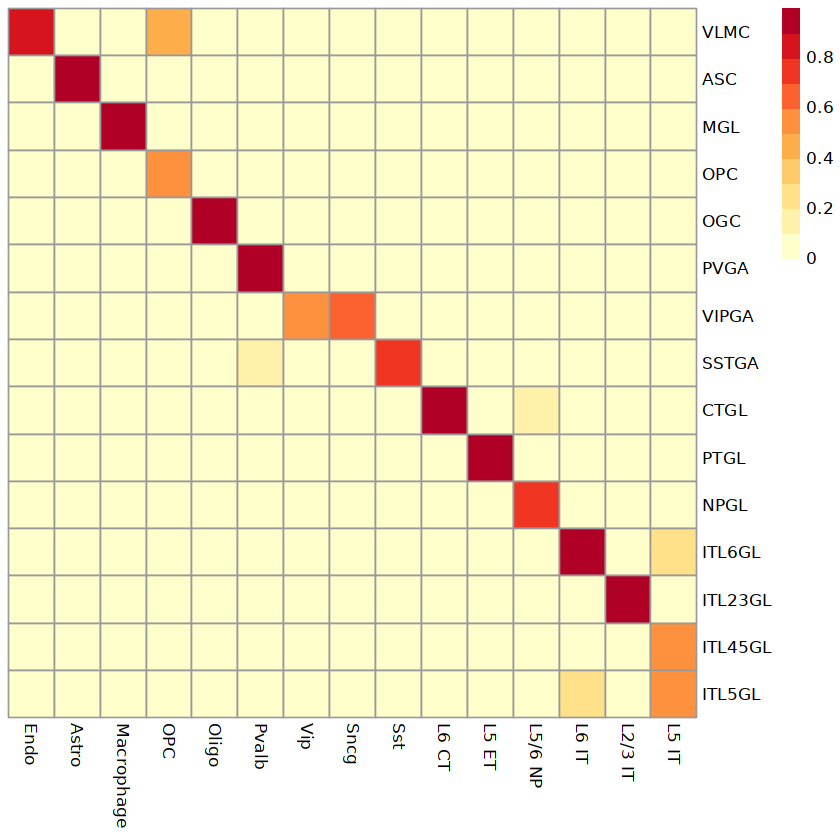

In [8]:
ovlpp <- cal_ovlpScore(obj@meta.data[!is.na(obj$Anno0.8_yel), c("integrated_snn_res.0.5", "Anno0.8_yel")],
             obj@meta.data[!is.na(obj$subclass_label), c("integrated_snn_res.0.5", "subclass_label")]) %>%
reshape2::dcast(anno1 ~ anno2) %>% 
tibble::column_to_rownames(var = "anno1") 
ovlpp_df <- ovlpp[corder[-c(6:8, 12, 14)], torder[-6]] %>% tibble::rownames_to_column("qry") %>% reshape2::melt()
match_pair2 <- ovlpp_df %>% dplyr::filter(value > 0.5) %>% dplyr::select(c("qry", "variable"))#  %>% setNames(c("DPT", "AIBS"))
match_pair2$pair <- paste0(match_pair2$qry, ":", match_pair2$variable)
match_pair2 <- match_pair2 %>% mutate(data = "DPT-AIBS")
plt2 <- ovlpp[corder[-c(6:8, 12, 14)], torder[-6]] %>%
pheatmap(cluster_rows = F, cluster_cols = F,
         color = colorRampPalette(brewer.pal(n = 8, name = "YlOrRd"))(10))

### Correlation: match vs unmatched

Using qry as id variables

Using qry as id variables

Using qry as id variables



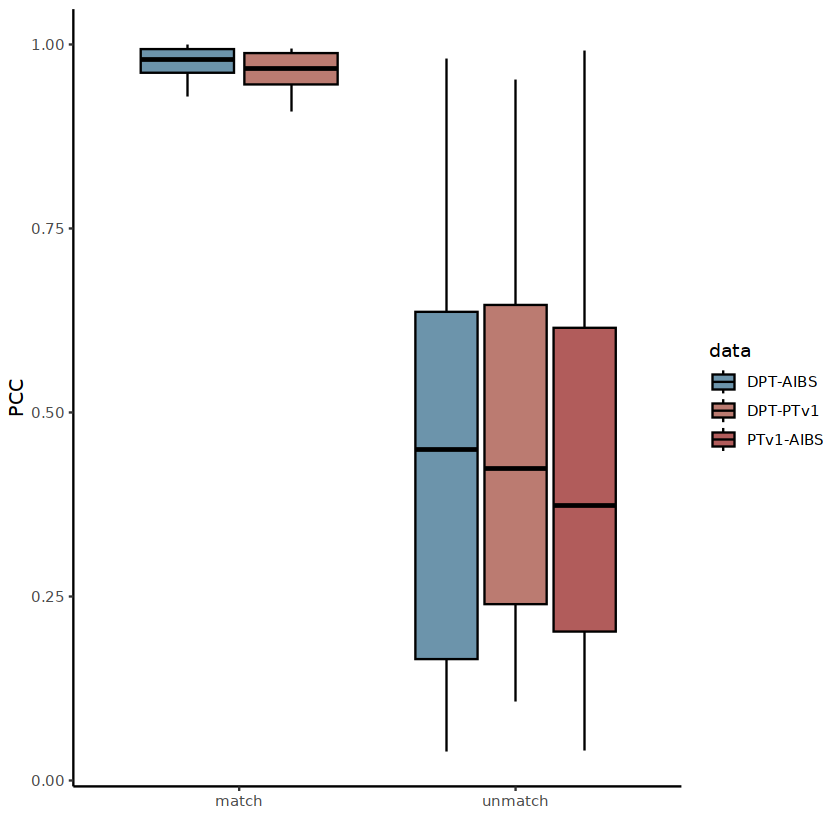

In [10]:
match_pair <- rbind(match_pair1, match_pair2)
obj$integrate <- NA
obj@meta.data[!is.na(obj$Annotation), ]$integrate <- obj@meta.data[!is.na(obj$Annotation), ]$Annotation
obj@meta.data[!is.na(obj$subclass_label), ]$integrate <- obj@meta.data[!is.na(obj$subclass_label), ]$subclass_label
obj@meta.data[!is.na(obj$Anno0.8_yel), ]$integrate <- obj@meta.data[!is.na(obj$Anno0.8_yel), ]$Anno0.8_yel

obj.int.Exp <- AverageExpression(obj, assays = "integrated", group.by = "integrate")

pcc_df <- list()
cell_type_list <- list(corder, rorder, torder)
compare <- data.frame(compare = c("DPT-PTv1", "DPT-AIBS", "PTv1-AIBS"),
                      data1 = c(1,1,2), 
                      data2 = c(2,3,3))

for (i in 1:nrow(compare)){
    tmp <- cor(obj.int.Exp$integrated[,cell_type_list[[compare[i,"data1"]]]], 
               obj.int.Exp$integrated[,cell_type_list[[compare[i,"data2"]]]]) %>% 
    as.data.frame() %>% tibble::rownames_to_column("qry") %>% reshape2::melt()
    tmp$pair <- paste0(tmp$qry, ":", tmp$variable)
    p <- match_pair[match_pair$data == compare[i, "compare",], ]$pair
    pcc_match <- tmp[tmp$pair %in% p, ] %>% mutate(group = "match")
    pcc_unmatch <- tmp[!(tmp$pair %in% p), ] %>% mutate(group = "unmatch")
    pcc_df[[compare[i, "compare",]]] <- rbind(pcc_match, pcc_unmatch)
    pcc_df[[compare[i, "compare",]]]$data <- compare[i, "compare",]
}

t1 <- do.call(rbind, pcc_df) %>%
ggplot(aes(x = group, y = value)) + 
geom_boxplot(aes(fill = data), color="black", alpha=0.8, coef = 1.5, outlier.shape = NA) + 
theme_classic() + 
scale_fill_manual(values = colfunc2(6)) + 
xlab("") + ylab("PCC")
t1

### Example: PVGA (PValb+ Neurons)

Scale for x is already present.
Adding another scale for x, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Warning message:
"Removed 173 rows containing missing values (`geom_point()`)."
Scale for x is already present.
Adding another scale for x, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Warning message:
"Removed 291 rows containing missing values (`geom_point()`)."


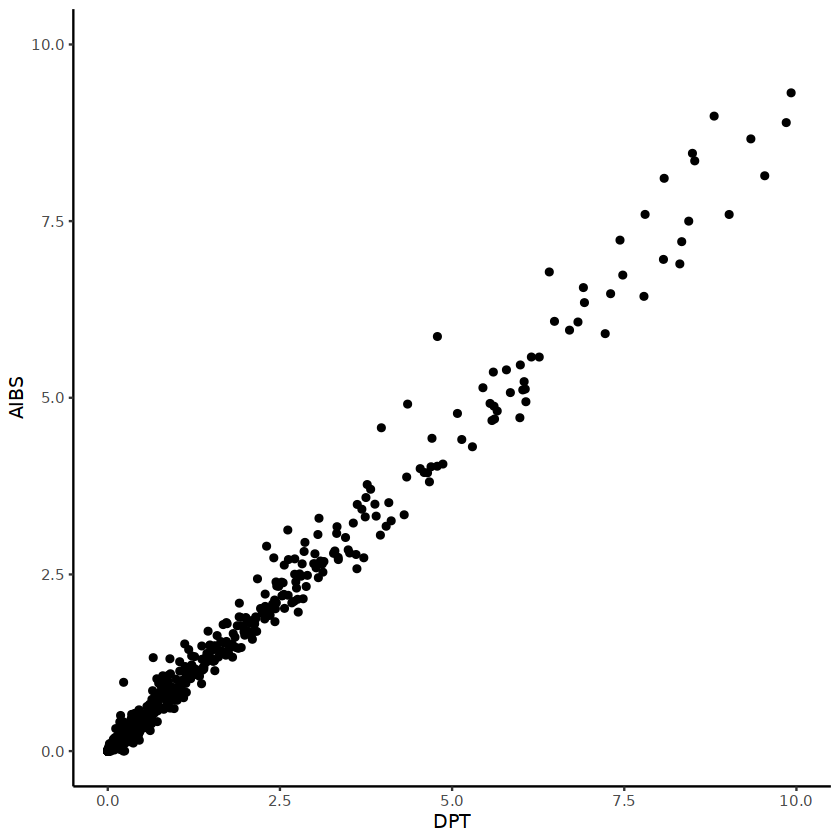

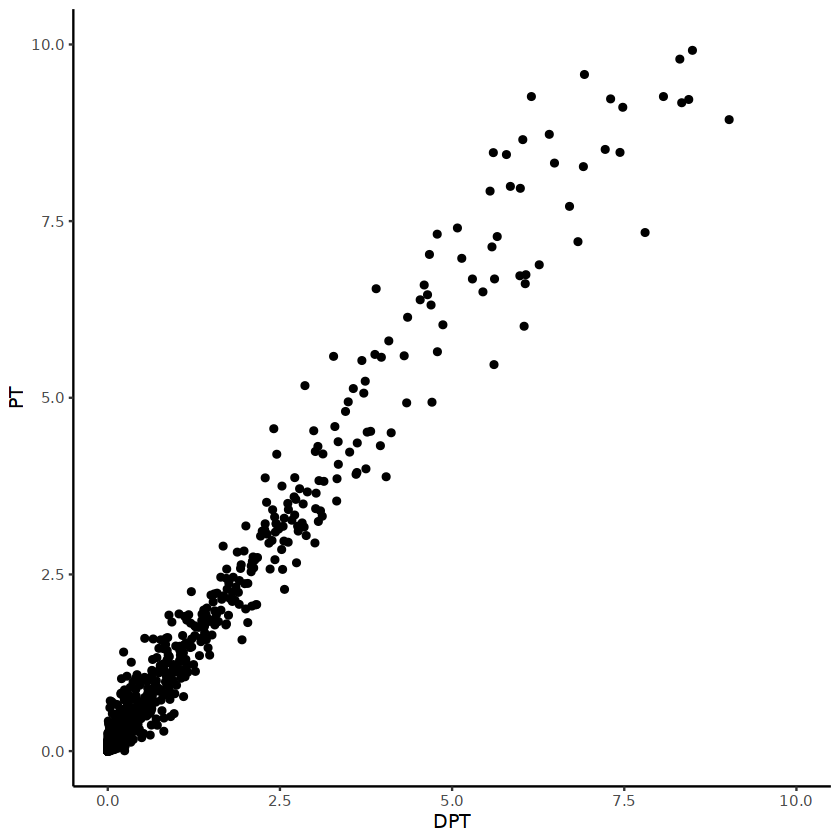

In [11]:
obj.int.Exp$integrated[,c("Pvalb", "PVGA", "BR_InNeu_Pvalb")] %>%
as.data.frame() %>% 
ggplot(aes(x = PVGA, y = Pvalb)) + 
geom_point() + 
theme_classic() + 
scale_x_log10() + scale_y_log10() + 
xlim(c(0,10)) + ylim(c(0,10)) + 
xlab("DPT") + ylab("AIBS")

obj.int.Exp$integrated[,c("Pvalb", "PVGA", "BR_InNeu_Pvalb")] %>%
as.data.frame() %>% 
ggplot(aes(x = PVGA, y = BR_InNeu_Pvalb)) + 
geom_point() + 
theme_classic() + 
scale_x_log10() + scale_y_log10() + 
xlim(c(0,10)) + ylim(c(0,10)) + 
xlab("DPT") + ylab("PT")